In [ ]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Plot 3-pane chart (NO HIGHLIGHTS)
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


make a cumulative volume indicator, but always starts calculating at the market open and resets after market close. put it on a separate pane, {}

Make the cumulative volume indicator calculation based on the time of the candlestick. The beginning calculation should start at the very first candlestick on the day, and end on the same day

use UTC+8 asia/manila timezone

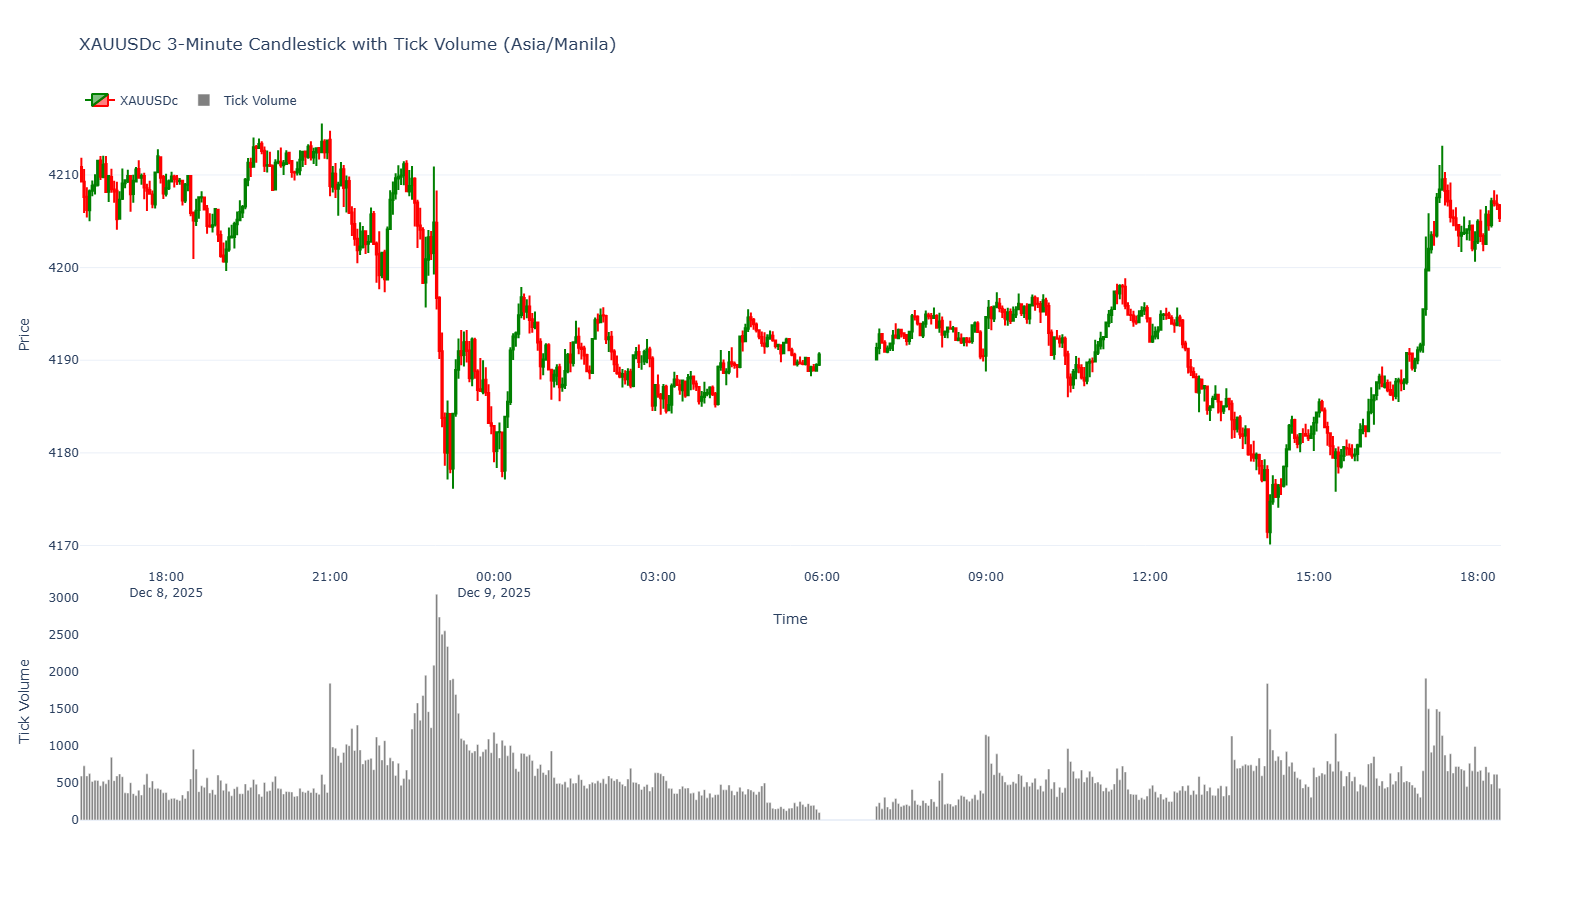

In [7]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
import pytz  # for timezone handling

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Convert to Asia/Manila timezone (UTC+8)
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Plot 2-Pane Chart
# -------------------------
fig = go.Figure()

# --- Pane 1: Candlestick ---
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# --- Pane 2: Tick Volume ---
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# -------------------------
# 6. Layout
# -------------------------
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Tick Volume (Asia/Manila)',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(
        title='Price',
        domain=[0.35, 1]
    ),
    yaxis2=dict(
        title='Tick Volume',
        domain=[0.0, 0.33],
        showgrid=False
    ),

    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


In [ ]:
locate the first candle and the last candle of the intraday, highlight the corresponding tick volume bar

I'm not talking about time-based here; I'm talking about market open and market close, which includes premarket and overnight sessions 

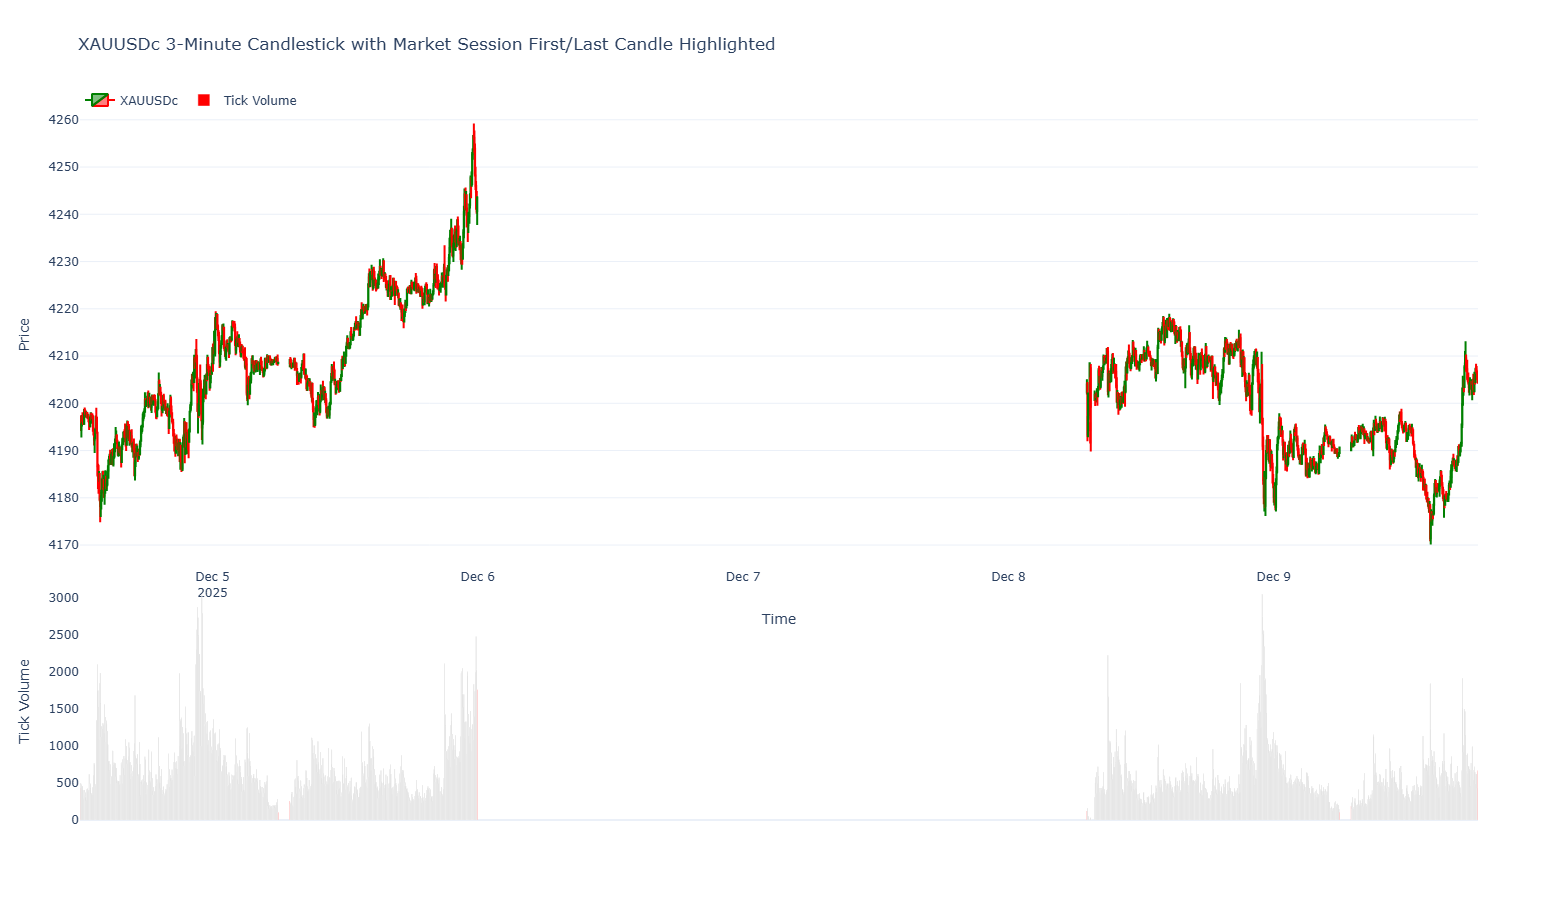

In [10]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import pytz

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key based on market open (06:00) to market close (next day 05:00)
# -------------------------
market_open = time(6, 0)
market_close = time(5, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        # belongs to previous day's session
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify first and last candle of each session
# -------------------------
first_candle_idx = df.groupby('session').head(1).index
last_candle_idx = df.groupby('session').tail(1).index

# -------------------------
# 7. Plot 2-Pane Chart
# -------------------------
fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick Volume with highlighted first/last bars
colors = ['red' if idx in first_candle_idx or idx in last_candle_idx else 'gray' for idx in df.index]
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color=colors,
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Market Session First/Last Candle Highlighted',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.0, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


ok now, calculate the cumulative volume from market open to market close

How about using a breakline for visualizing cumulative volume

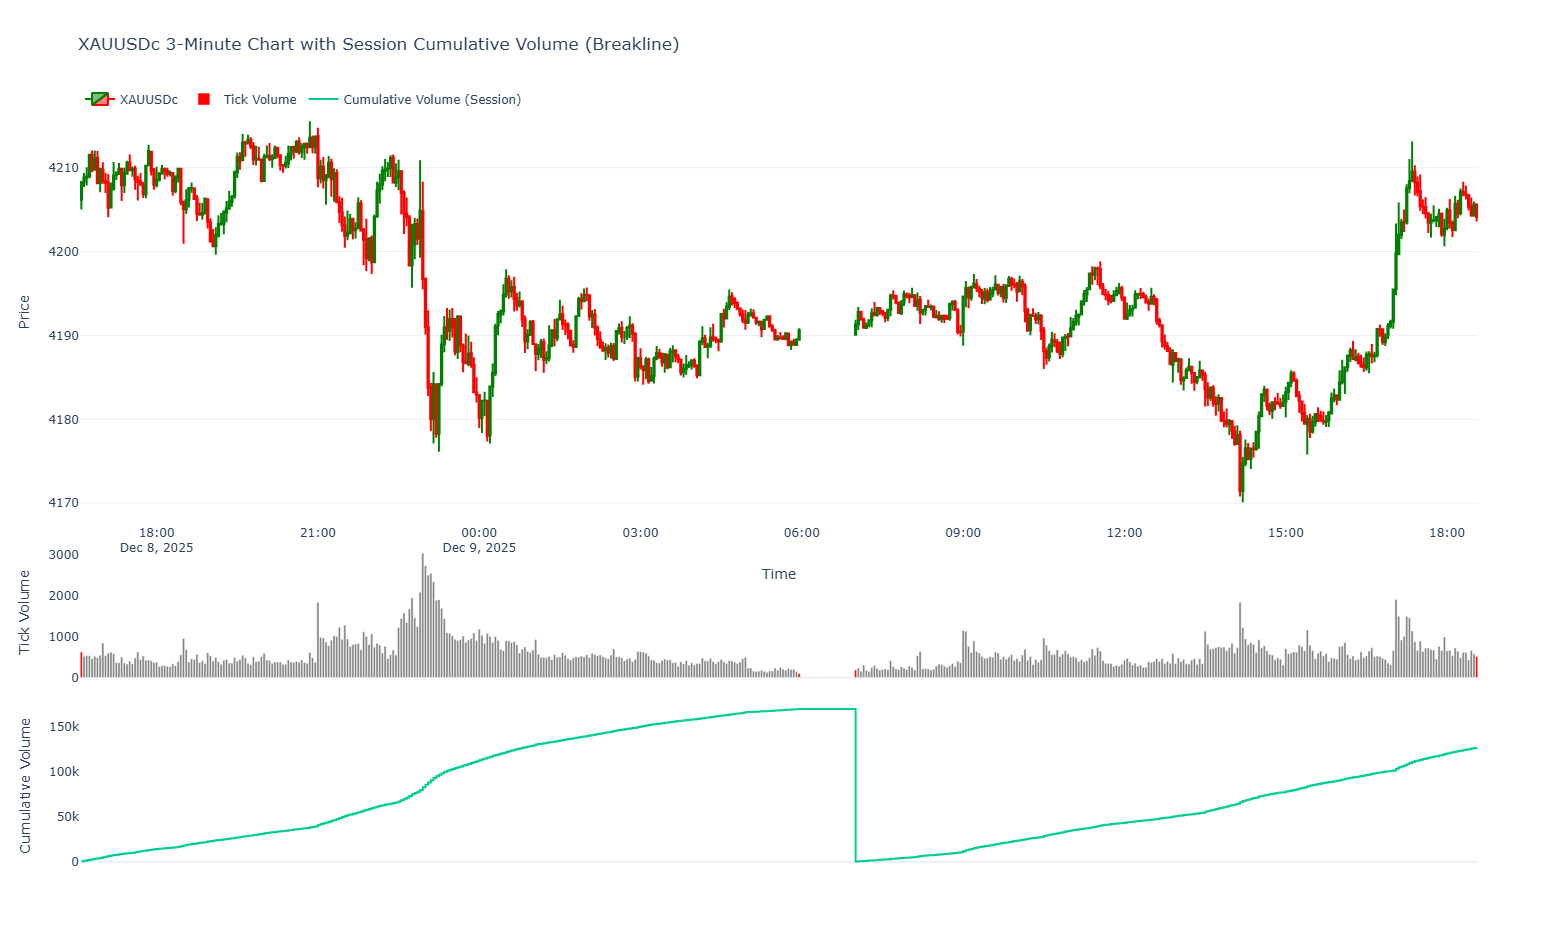

In [16]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import pytz

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key based on market open (06:00) to market close (next day 05:00)
# -------------------------
market_open = time(6, 0)
market_close = time(5, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify first and last candle of each session
# -------------------------
first_candle_idx = df.groupby('session').head(1).index
last_candle_idx = df.groupby('session').tail(1).index

# -------------------------
# 7. Calculate cumulative volume per session
# -------------------------
df['cum_volume'] = df.groupby('session')['tick_volume'].cumsum()

# -------------------------
# 8. Plot 3-Pane Chart with breakline for cumulative volume
# -------------------------
fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick Volume with first/last candle highlighted
colors = ['red' if idx in first_candle_idx or idx in last_candle_idx else 'gray' for idx in df.index]
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color=colors,
    yaxis='y2'
))

# Cumulative Volume (step/breakline)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['cum_volume'],
    name='Cumulative Volume (Session)',
    mode='lines',
    line=dict(width=2),
    yaxis='y3',
    line_shape='hv'  # horizontal-vertical step plot
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart with Session Cumulative Volume (Breakline)',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.45, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.25, 0.42], showgrid=False),
    yaxis3=dict(title='Cumulative Volume', domain=[0.0, 0.22], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=950
)

fig.show()


Compare the current volume bar value to the corresponding cumulative-volume bar. Color the corresponding candlestick blue if the volume bar value is near the cumulative volume value (the darker the color, the nearer the value to the cumulative volume, and the green color the lesser the value). 

dynamic candlestick coloring based on the relationship between the tick volume and cumulative volume. Essentially:
    Darker blue → current tick volume is very close to the cumulative volume at that candle.
    Green → current tick volume is small relative to the cumulative volume.
    This comparison is done per session.

We can achieve this by:
    Normalizing the current tick volume relative to the session cumulative volume.
    Using a color scale from green → blue based on proximity.

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import pytz

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key based on market open (06:00) to market close (next day 05:00)
# -------------------------
market_open = time(6, 0)

def get_session(dt):
    return dt.date() if dt.time() >= market_open else (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Calculate cumulative volume per session
# -------------------------
df['cum_volume'] = df.groupby('session')['tick_volume'].cumsum()

# -------------------------
# 7. Determine candlestick colors based on volume proximity
# -------------------------
def volume_to_color(row):
    # Avoid division by zero
    if row['cum_volume'] == 0:
        return 'green'
    # Normalize proximity: 0 = low, 1 = very close
    proximity = min(row['tick_volume'] / row['cum_volume'], 1)
    # Map proximity to color: green (low) → dark blue (high)
    # Simple RGB interpolation: green=(0,255,0), blue=(0,0,139)
    r = 0
    g = int(255 * (1 - proximity))
    b = int(139 + 116 * proximity)  # 139→255 for stronger blue
    return f'rgb({r},{g},{b})'

df['candle_color'] = df.apply(volume_to_color, axis=1)

# -------------------------
# 8. Plot 3-Pane Chart
# -------------------------
fig = go.Figure()

# Candlestick colored based on volume proximity
for idx, row in df.iterrows():
    fig.add_trace(go.Candlestick(
        x=[idx],
        open=[row['open']],
        high=[row['high']],
        low=[row['low']],
        close=[row['close']],
        increasing_line_color=row['candle_color'],
        decreasing_line_color=row['candle_color'],
        showlegend=False
    ))

# Tick Volume with first/last candle highlighted
first_candle_idx = df.groupby('session').head(1).index
last_candle_idx = df.groupby('session').tail(1).index
colors = ['red' if idx in first_candle_idx or idx in last_candle_idx else 'gray' for idx in df.index]

fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color=colors,
    yaxis='y2'
))

# Cumulative Volume (breakline)
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['cum_volume'],
    name='Cumulative Volume (Session)',
    mode='lines',
    line=dict(width=2),
    yaxis='y3',
    line_shape='hv'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Chart: Candles Colored by Volume vs Cumulative Volume',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.45, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.25, 0.42], showgrid=False),
    yaxis3=dict(title='Cumulative Volume', domain=[0.0, 0.22], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=950
)

fig.show()
